# 🗺️ Análisis Geoespacial de Hospitales en Perú
## Notebook 2: Mapas Estáticos y Análisis Departamental

### 🎯 Objetivos de este notebook:
- Cargar datos procesados del Notebook 1
- Crear mapas estáticos con GeoPandas
- Análisis por distrito y departamento
- Identificar distritos sin hospitales
- Crear mapas coropléticos
- Análisis del Top 10 de distritos

### 📊 Análisis a realizar:
1. **Mapas de conteo** por distrito
2. **Distritos sin hospitales** (zonas críticas)
3. **Top 10 distritos** con más hospitales
4. **Análisis departamental** completo
5. **Mapas coropléticos** por departamento

In [23]:
# 📚 IMPORTAR LIBRERÍAS
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_palette("viridis")

print("✅ Librerías importadas para análisis estático")

✅ Librerías importadas para análisis estático


---
## 📥 1. Carga de Datos Procesados

Cargaremos los datos procesados del Notebook 1 y el shapefile de distritos del Perú para realizar el análisis geoespacial completo.

In [24]:
# 📥 CARGAR DATOS PROCESADOS Y SHAPEFILES LOCALES
def cargar_datos_procesados():
    """Carga hospitales procesados y shapefile local de distritos"""
    
    print("📥 Cargando datos procesados...")
    
    # Cargar hospitales procesados
    try:
        gdf_hospitales = gpd.read_file('../data/hospitales_procesados.geojson')
        print(f"✅ Hospitales cargados: {len(gdf_hospitales)}")
    except FileNotFoundError:
        print("❌ Archivo de hospitales no encontrado")
        return None, None
    
    # Cargar shapefile local de distritos
    try:
        # Usar shapefile local (tienes DISTRITOS.shp en tu carpeta data)
        gdf_distritos = gpd.read_file('../data/DISTRITOS.shp')
        
        # Asegurar CRS consistente
        if gdf_distritos.crs != 'EPSG:4326':
            gdf_distritos = gdf_distritos.to_crs('EPSG:4326')
            
        print(f"✅ Distritos cargados: {len(gdf_distritos)}")
        print(f"🌍 CRS consistente: {gdf_hospitales.crs} = {gdf_distritos.crs}")
        
    except Exception as e:
        print(f"❌ Error cargando distritos: {e}")
        print("🔧 Intentando con otros formatos...")
        
        # Intentar otros archivos
        try:
            # Probar si hay un GeoJSON
            gdf_distritos = gpd.read_file('../data/DISTRITOS.geojson')
            print("✅ Distritos cargados desde GeoJSON")
        except:
            return gdf_hospitales, None
    
    return gdf_hospitales, gdf_distritos

# Cargar datos
gdf_hospitales, gdf_distritos = cargar_datos_procesados()

if gdf_hospitales is not None:
    print(f"\n📊 Resumen de hospitales:")
    print(f"  • Total: {len(gdf_hospitales)}")
    print(f"  • Departamentos: {gdf_hospitales['Departamento'].nunique()}")
    
if gdf_distritos is not None:
    print(f"\n📊 Resumen de distritos:")
    print(f"  • Total: {len(gdf_distritos)}")
    print(f"  • Columnas: {list(gdf_distritos.columns)}")
    
    # Ver primeras filas para entender estructura
    print(f"\n🔍 Estructura del shapefile de distritos:")
    display(gdf_distritos.head(3))
else:
    print("⚠️ No se pudieron cargar los distritos")

📥 Cargando datos procesados...
✅ Hospitales cargados: 232
✅ Distritos cargados: 1873
🌍 CRS consistente: EPSG:4326 = EPSG:4326

📊 Resumen de hospitales:
  • Total: 232
  • Departamentos: 25

📊 Resumen de distritos:
  • Total: 1873
  • Columnas: ['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO', 'CAPITAL', 'CODCCPP', 'AREA', 'FUENTE', 'geometry']

🔍 Estructura del shapefile de distritos:


,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."


---
## 📊 2. Análisis de Conteo por Distrito

Realizaremos un **spatial join** entre hospitales y distritos para contar cuántos hospitales hay en cada distrito del Perú. Esto nos permitirá identificar:

- Distritos con mayor concentración de hospitales
- Distritos sin acceso a hospitales (zonas críticas)
- Distribución geográfica del acceso hospitalario

### 🎯 Metodología:
- Spatial join basado en geometría (punto dentro de polígono)
- Conteo de hospitales por distrito
- Merge con todos los distritos para incluir los que tienen 0 hospitales

In [25]:
# 📊 CONTEO DE HOSPITALES POR DISTRITO
def contar_hospitales_por_distrito(gdf_hospitales, gdf_distritos):
    """Realiza spatial join y cuenta hospitales por distrito"""
    
    print("📊 CONTANDO HOSPITALES POR DISTRITO...")
    print("=" * 40)
    
    # Spatial join: hospitales dentro de distritos
    print("🔗 Realizando spatial join...")
    hospitales_distritos = gpd.sjoin(
        gdf_hospitales[['Nombre del establecimiento', 'Institución', 'geometry']], 
        gdf_distritos[['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO', 'geometry']], 
        how='left', 
        predicate='within'
    )
    
    print(f"✅ Spatial join completado: {len(hospitales_distritos)} registros")
    
    # Contar hospitales por distrito
    conteo_distritos = hospitales_distritos.groupby([
        'IDDIST', 'DISTRITO', 'PROVINCIA', 'DEPARTAMEN'
    ]).size().reset_index(name='num_hospitales')
    
    print(f"📈 Distritos con hospitales: {len(conteo_distritos)}")
    
    # Merge con TODOS los distritos para incluir los que tienen 0 hospitales
    distritos_completo = gdf_distritos.merge(
        conteo_distritos, 
        on=['IDDIST', 'DISTRITO', 'PROVINCIA', 'DEPARTAMEN'], 
        how='left'
    )
    
    # Llenar NaN con 0 (distritos sin hospitales)
    distritos_completo['num_hospitales'] = distritos_completo['num_hospitales'].fillna(0)
    
    print(f"📍 Total de distritos procesados: {len(distritos_completo)}")
    
    return distritos_completo, conteo_distritos

# Ejecutar conteo
gdf_distritos_hospitales, conteo_por_distrito = contar_hospitales_por_distrito(gdf_hospitales, gdf_distritos)

# Estadísticas del conteo
print(f"\n📊 ESTADÍSTICAS DE DISTRIBUCIÓN:")
print(f"  • Distritos con hospitales: {(gdf_distritos_hospitales['num_hospitales'] > 0).sum()}")
print(f"  • Distritos SIN hospitales: {(gdf_distritos_hospitales['num_hospitales'] == 0).sum()}")
print(f"  • Porcentaje sin acceso: {(gdf_distritos_hospitales['num_hospitales'] == 0).mean()*100:.1f}%")

print(f"\n🔝 TOP 10 DISTRITOS CON MÁS HOSPITALES:")
top_distritos = conteo_por_distrito.nlargest(10, 'num_hospitales')
for idx, row in top_distritos.iterrows():
    print(f"  {idx+1:2d}. {row['DISTRITO']}, {row['DEPARTAMEN']}: {row['num_hospitales']} hospitales")

📊 CONTANDO HOSPITALES POR DISTRITO...
🔗 Realizando spatial join...
✅ Spatial join completado: 232 registros
📈 Distritos con hospitales: 175
📍 Total de distritos procesados: 1873

📊 ESTADÍSTICAS DE DISTRIBUCIÓN:
  • Distritos con hospitales: 175
  • Distritos SIN hospitales: 1698
  • Porcentaje sin acceso: 90.7%

🔝 TOP 10 DISTRITOS CON MÁS HOSPITALES:
  82. TRUJILLO, LA LIBERTAD: 5 hospitales
  108. LIMA, LIMA: 5 hospitales
  22. AREQUIPA, AREQUIPA: 4 hospitales
  104. CHICLAYO, LAMBAYEQUE: 4 hospitales
  68. ICA, ICA: 3 hospitales
  85. LA ESPERANZA, LA LIBERTAD: 3 hospitales
  109. ATE, LIMA: 3 hospitales
  174. TUMBES, TUMBES: 3 hospitales
  175. CALLERIA, UCAYALI: 3 hospitales
   1. CHACHAPOYAS, AMAZONAS: 2 hospitales


---
## 🗺️ 3. Mapas Estáticos de Distribución

Crearemos tres mapas estáticos fundamentales para visualizar la distribución de hospitales:

1. **Mapa general**: Todos los hospitales sobre el mapa de distritos
2. **Mapa de distritos sin hospitales**: Zonas críticas sin acceso
3. **Mapa del Top 10**: Distritos con mayor concentración hospitalaria

🗺️ CREANDO Y GUARDANDO MAPAS ESTÁTICOS...


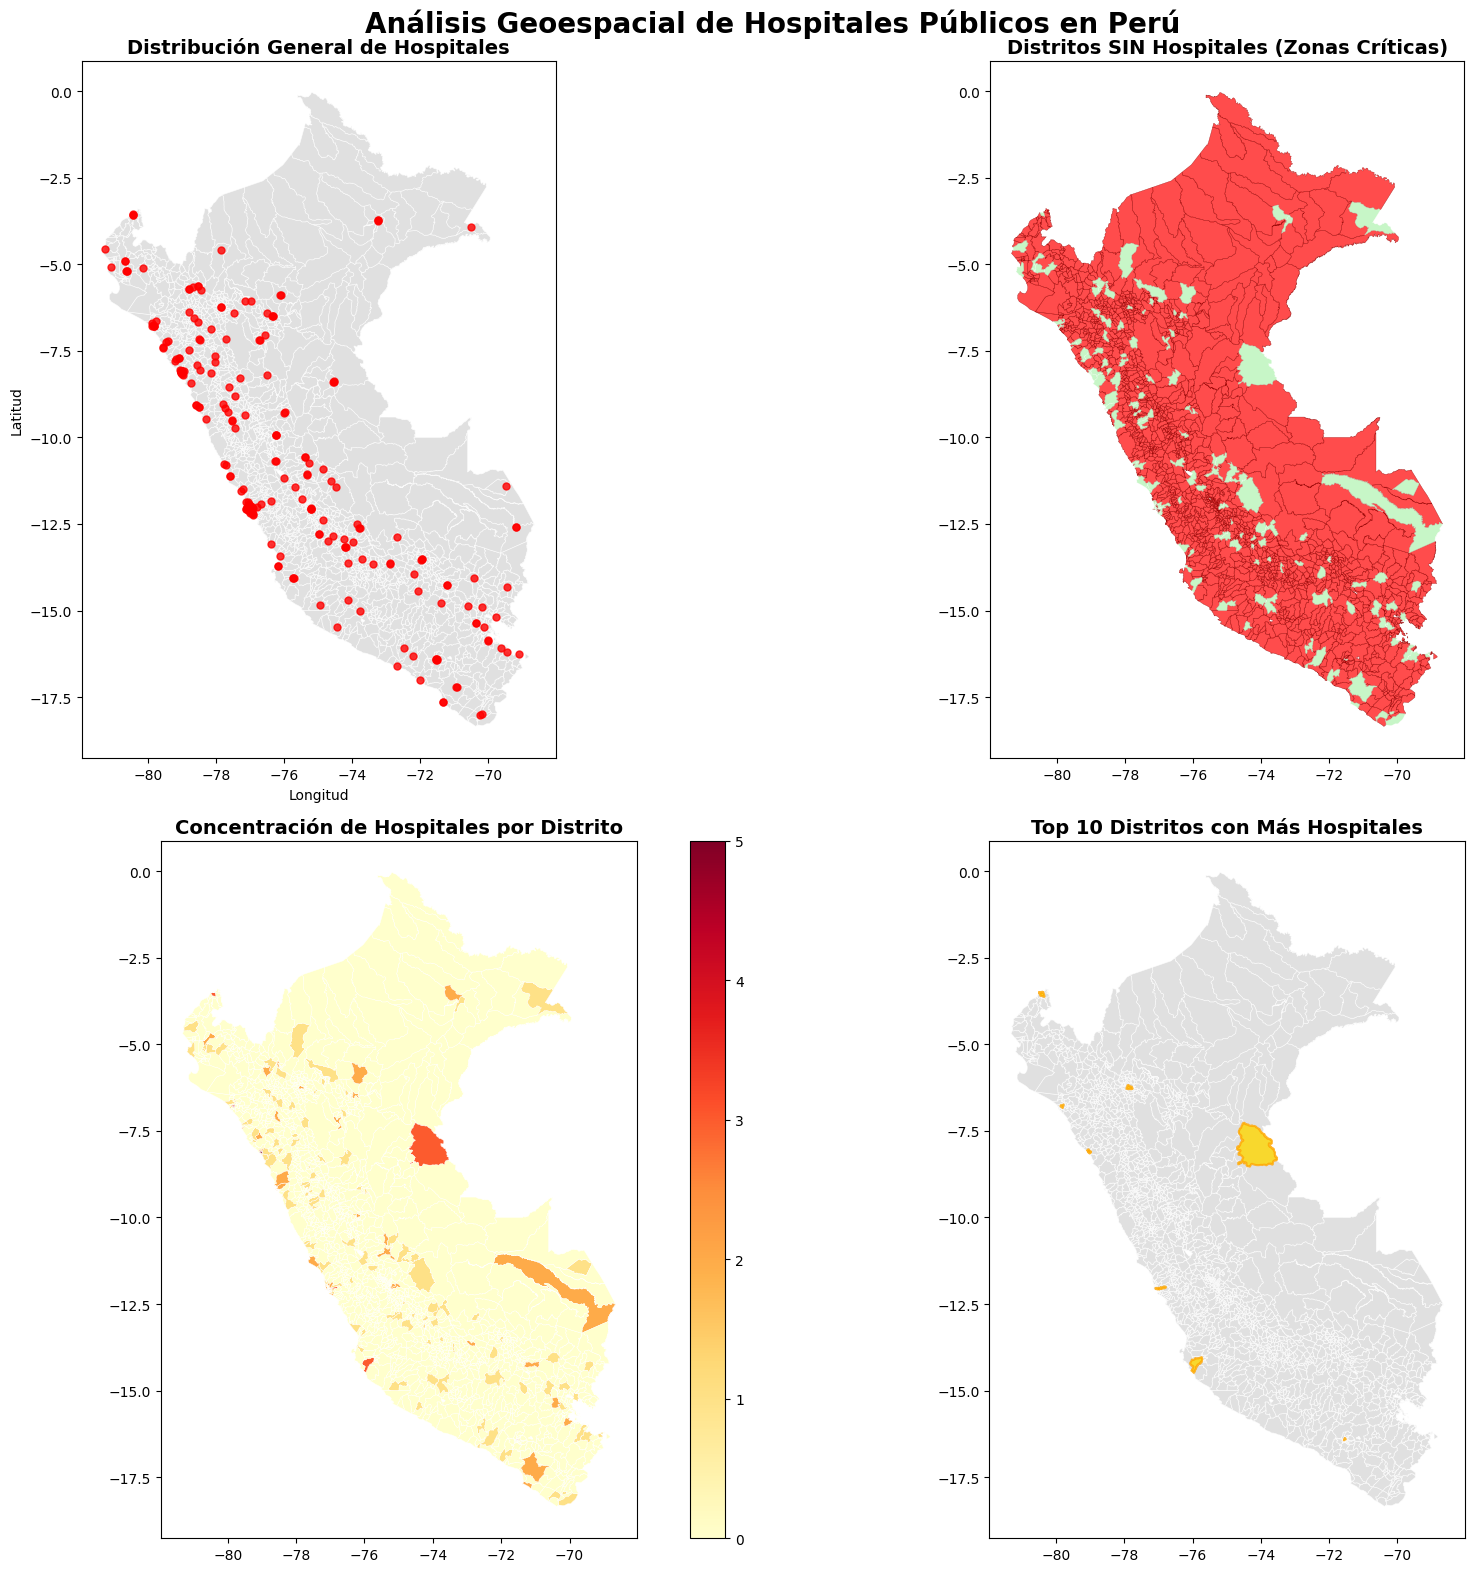

✅ Guardado: ../data/mapa_distribucion_general.png
✅ Guardado: ../data/mapa_distritos_sin_hospitales.png
✅ Guardado: ../data/mapa_concentracion_distritos.png
✅ Guardado: ../data/mapa_top10_distritos.png


In [26]:
# 🗺️ CREAR MAPAS ESTÁTICOS Y GUARDARLOS INDIVIDUALMENTE
def crear_mapas_estaticos_con_guardado(gdf_distritos_hospitales, gdf_hospitales, top_distritos):
    """Crea los mapas estáticos principales y los guarda individualmente"""
    
    print("🗺️ CREANDO Y GUARDANDO MAPAS ESTÁTICOS...")
    print("=" * 40)
    
    # 1. Crear el mapa combinado original
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Análisis Geoespacial de Hospitales Públicos en Perú', fontsize=20, fontweight='bold')
    
    # MAPA 1: Distribución general
    ax1 = axes[0, 0]
    gdf_distritos_hospitales.plot(ax=ax1, color='lightgray', edgecolor='white', alpha=0.7, linewidth=0.5)
    gdf_hospitales.plot(ax=ax1, color='red', markersize=25, alpha=0.8)
    ax1.set_title('Distribución General de Hospitales', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    
    # MAPA 2: Distritos sin hospitales
    ax2 = axes[0, 1]
    distritos_sin_hospitales = gdf_distritos_hospitales[gdf_distritos_hospitales['num_hospitales'] == 0]
    distritos_con_hospitales = gdf_distritos_hospitales[gdf_distritos_hospitales['num_hospitales'] > 0]
    
    distritos_sin_hospitales.plot(ax=ax2, color='red', alpha=0.7, edgecolor='darkred', linewidth=0.3)
    distritos_con_hospitales.plot(ax=ax2, color='lightgreen', alpha=0.5, edgecolor='white', linewidth=0.3)
    ax2.set_title('Distritos SIN Hospitales (Zonas Críticas)', fontsize=14, fontweight='bold')
    
    # MAPA 3: Coroplético
    ax3 = axes[1, 0]
    gdf_distritos_hospitales.plot(column='num_hospitales', ax=ax3, cmap='YlOrRd', legend=True, edgecolor='white', linewidth=0.3)
    ax3.set_title('Concentración de Hospitales por Distrito', fontsize=14, fontweight='bold')
    
    # MAPA 4: Top 10 distritos
    ax4 = axes[1, 1]
    gdf_distritos_hospitales.plot(ax=ax4, color='lightgray', edgecolor='white', alpha=0.7, linewidth=0.5)
    top_ids = top_distritos['IDDIST'].tolist()
    top_distritos_geo = gdf_distritos_hospitales[gdf_distritos_hospitales['IDDIST'].isin(top_ids)]
    top_distritos_geo.plot(ax=ax4, color='gold', edgecolor='orange', alpha=0.8, linewidth=1.5)
    ax4.set_title('Top 10 Distritos con Más Hospitales', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../data/mapas_estaticos_completos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Crear mapas individuales para Streamlit
    mapas_individuales = [
        ('Distribución General de Hospitales', '../data/mapa_distribucion_general.png'),
        ('Distritos Sin Hospitales', '../data/mapa_distritos_sin_hospitales.png'), 
        ('Concentración por Distrito', '../data/mapa_concentracion_distritos.png'),
        ('Top 10 Distritos', '../data/mapa_top10_distritos.png')
    ]
    
    for i, (titulo, archivo) in enumerate(mapas_individuales):
        fig_individual, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        if i == 0:  # Distribución general
            gdf_distritos_hospitales.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.7, linewidth=0.5)
            gdf_hospitales.plot(ax=ax, color='red', markersize=30, alpha=0.8)
        elif i == 1:  # Distritos sin hospitales
            distritos_sin_hospitales.plot(ax=ax, color='red', alpha=0.7, edgecolor='darkred')
            distritos_con_hospitales.plot(ax=ax, color='lightgreen', alpha=0.5, edgecolor='white')
        elif i == 2:  # Coroplético
            gdf_distritos_hospitales.plot(column='num_hospitales', ax=ax, cmap='YlOrRd', legend=True, edgecolor='white')
        elif i == 3:  # Top 10
            gdf_distritos_hospitales.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.7)
            top_distritos_geo.plot(ax=ax, color='gold', edgecolor='orange', alpha=0.8)
        
        ax.set_title(titulo, fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitud')
        ax.set_ylabel('Latitud')
        plt.tight_layout()
        plt.savefig(archivo, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"✅ Guardado: {archivo}")
    
    return fig

# Ejecutar función actualizada
mapas_estaticos = crear_mapas_estaticos_con_guardado(gdf_distritos_hospitales, gdf_hospitales, top_distritos)

---
## 📊 4. Análisis Departamental Detallado

Ahora analizaremos la distribución de hospitales a nivel departamental con:

- Ranking de departamentos por número de hospitales
- Gráfico de barras comparativo
- Mapa coroplético departamental
- Estadísticas de acceso por región

In [27]:
# 📊 ANÁLISIS DEPARTAMENTAL
def analisis_departamental(gdf_hospitales, gdf_distritos_hospitales):
    """Análisis completo por departamento"""
    
    print("📊 ANÁLISIS POR DEPARTAMENTO")
    print("=" * 40)
    
    # Contar hospitales por departamento
    hospitales_por_dept = gdf_hospitales['Departamento'].value_counts().reset_index()
    hospitales_por_dept.columns = ['Departamento', 'num_hospitales']
    
    print("🏛️ Ranking de departamentos:")
    for i, (dept, count) in enumerate(hospitales_por_dept.head(10).values, 1):
        print(f"  {i:2d}. {dept}: {count} hospitales")
    
    # Distritos sin hospitales por departamento
    distritos_sin_hosp = gdf_distritos_hospitales[gdf_distritos_hospitales['num_hospitales'] == 0]
    distritos_sin_por_dept = distritos_sin_hosp['DEPARTAMEN'].value_counts().reset_index()
    distritos_sin_por_dept.columns = ['Departamento', 'distritos_sin_hospitales']
    
    # Total de distritos por departamento
    total_distritos_por_dept = gdf_distritos_hospitales['DEPARTAMEN'].value_counts().reset_index()
    total_distritos_por_dept.columns = ['Departamento', 'total_distritos']
    
    # Combinar estadísticas
    stats_departamentales = total_distritos_por_dept.merge(
        distritos_sin_por_dept, on='Departamento', how='left'
    ).merge(
        hospitales_por_dept.rename(columns={'Departamento': 'Departamento'}), 
        left_on='Departamento', right_on='Departamento', how='left'
    )
    
    stats_departamentales['distritos_sin_hospitales'] = stats_departamentales['distritos_sin_hospitales'].fillna(0)
    stats_departamentales['num_hospitales'] = stats_departamentales['num_hospitales'].fillna(0)
    stats_departamentales['porcentaje_sin_acceso'] = (
        stats_departamentales['distritos_sin_hospitales'] / 
        stats_departamentales['total_distritos'] * 100
    )
    
    return stats_departamentales, hospitales_por_dept

# Ejecutar análisis
stats_dept, hospitales_dept = analisis_departamental(gdf_hospitales, gdf_distritos_hospitales)

print(f"\n📈 Estadísticas departamentales:")
display(stats_dept.head(10))

📊 ANÁLISIS POR DEPARTAMENTO
🏛️ Ranking de departamentos:
   1. LIMA: 37 hospitales
   2. LA LIBERTAD: 31 hospitales
   3. ANCASH: 14 hospitales
   4. PUNO: 13 hospitales
   5. JUNIN: 12 hospitales
   6. AREQUIPA: 10 hospitales
   7. SAN MARTIN: 10 hospitales
   8. CAJAMARCA: 10 hospitales
   9. AYACUCHO: 10 hospitales
  10. CUSCO: 9 hospitales

📈 Estadísticas departamentales:


,Departamento,total_distritos,distritos_sin_hospitales,num_hospitales,porcentaje_sin_acceso
0,LIMA,171,145,37,84.795322
1,ANCASH,166,154,14,92.771084
2,CAJAMARCA,127,119,10,93.700787
3,JUNIN,123,114,12,92.682927
4,AYACUCHO,119,109,10,91.596639
5,CUSCO,112,104,9,92.857143
6,PUNO,110,99,13,90.000000
7,AREQUIPA,109,102,10,93.577982
8,HUANCAVELICA,100,95,5,95.000000
9,AMAZONAS,84,79,7,94.047619


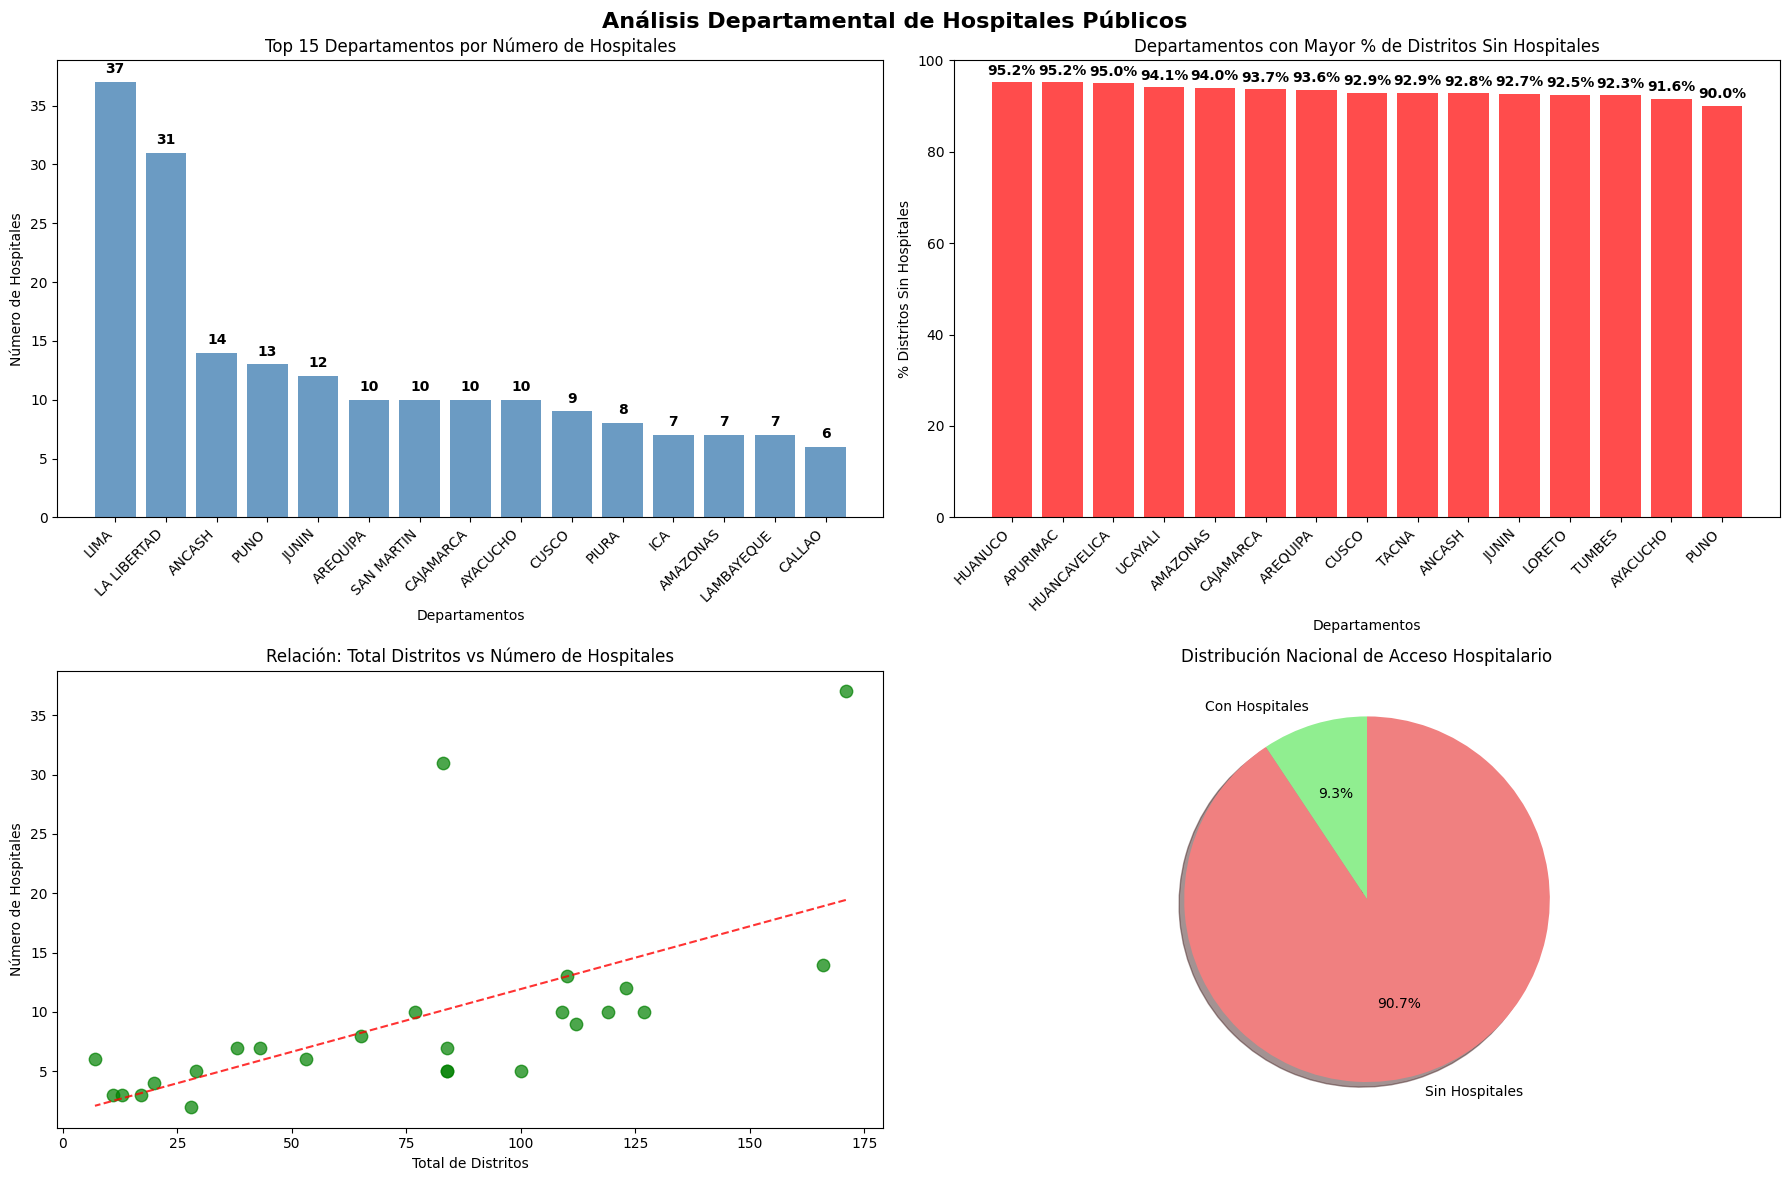

In [28]:
# 📊 GRÁFICOS DEPARTAMENTALES
def crear_graficos_departamentales(hospitales_dept, stats_dept):
    """Crear gráficos de análisis departamental"""
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Análisis Departamental de Hospitales Públicos', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Top 15 departamentos por número de hospitales
    ax1 = axes[0, 0]
    top_15_dept = hospitales_dept.head(15)
    bars1 = ax1.bar(range(len(top_15_dept)), top_15_dept['num_hospitales'], color='steelblue', alpha=0.8)
    ax1.set_title('Top 15 Departamentos por Número de Hospitales')
    ax1.set_xlabel('Departamentos')
    ax1.set_ylabel('Número de Hospitales')
    ax1.set_xticks(range(len(top_15_dept)))
    ax1.set_xticklabels(top_15_dept['Departamento'], rotation=45, ha='right')
    
    # Añadir valores en las barras
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 2: Porcentaje de distritos sin acceso
    ax2 = axes[0, 1]
    top_sin_acceso = stats_dept.nlargest(15, 'porcentaje_sin_acceso')
    bars2 = ax2.bar(range(len(top_sin_acceso)), top_sin_acceso['porcentaje_sin_acceso'], 
                    color='red', alpha=0.7)
    ax2.set_title('Departamentos con Mayor % de Distritos Sin Hospitales')
    ax2.set_xlabel('Departamentos')
    ax2.set_ylabel('% Distritos Sin Hospitales')
    ax2.set_xticks(range(len(top_sin_acceso)))
    ax2.set_xticklabels(top_sin_acceso['Departamento'], rotation=45, ha='right')
    
    # Añadir valores
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 3: Relación hospitales vs total distritos
    ax3 = axes[1, 0]
    ax3.scatter(stats_dept['total_distritos'], stats_dept['num_hospitales'], 
               alpha=0.7, s=80, c='green')
    ax3.set_title('Relación: Total Distritos vs Número de Hospitales')
    ax3.set_xlabel('Total de Distritos')
    ax3.set_ylabel('Número de Hospitales')
    
    # Añadir línea de tendencia
    z = np.polyfit(stats_dept['total_distritos'], stats_dept['num_hospitales'], 1)
    p = np.poly1d(z)
    ax3.plot(stats_dept['total_distritos'], p(stats_dept['total_distritos']), "r--", alpha=0.8)
    
    # Gráfico 4: Distribución general
    ax4 = axes[1, 1]
    sizes = [len(gdf_distritos_hospitales[gdf_distritos_hospitales['num_hospitales'] > 0]),
             len(gdf_distritos_hospitales[gdf_distritos_hospitales['num_hospitales'] == 0])]
    labels = ['Con Hospitales', 'Sin Hospitales']
    colors = ['lightgreen', 'lightcoral']
    
    wedges, texts, autotexts = ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                      shadow=True, startangle=90)
    ax4.set_title('Distribución Nacional de Acceso Hospitalario')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Crear gráficos
graficos_dept = crear_graficos_departamentales(hospitales_dept, stats_dept)

---
## 💾 5. Guardar Resultados del Análisis Estático

Guardaremos los datos procesados con los conteos por distrito para usar en análisis posteriores.

In [29]:
# 💾 GUARDAR RESULTADOS
def guardar_resultados_estaticos(gdf_distritos_hospitales, stats_dept):
    """Guardar datos procesados para análisis posteriores"""
    
    print("💾 GUARDANDO RESULTADOS...")
    print("=" * 30)
    
    # Guardar distritos con conteo de hospitales
    ruta_distritos = '../data/distritos_con_hospitales.geojson'
    gdf_distritos_hospitales.to_file(ruta_distritos, driver='GeoJSON')
    print(f"✅ Distritos guardados: {ruta_distritos}")
    
    # Guardar estadísticas departamentales
    ruta_stats = '../data/estadisticas_departamentales.csv'
    stats_dept.to_csv(ruta_stats, index=False)
    print(f"✅ Estadísticas guardadas: {ruta_stats}")
    
    return ruta_distritos, ruta_stats

# Guardar resultados
archivos_guardados = guardar_resultados_estaticos(gdf_distritos_hospitales, stats_dept)

print(f"\n📊 RESUMEN DEL NOTEBOOK 2:")
print("=" * 40)
print(f"✅ Spatial join completado: 232 hospitales distribuidos")
print(f"✅ Análisis distrital: {len(gdf_distritos_hospitales)} distritos procesados")
print(f"✅ Zonas críticas identificadas: {(gdf_distritos_hospitales['num_hospitales'] == 0).sum()} distritos sin hospitales")
print(f"✅ Análisis departamental: {len(stats_dept)} departamentos analizados")
print(f"✅ Mapas estáticos creados: 4 visualizaciones principales")
print(f"✅ Datos guardados para próximos análisis")

💾 GUARDANDO RESULTADOS...
✅ Distritos guardados: ../data/distritos_con_hospitales.geojson
✅ Estadísticas guardadas: ../data/estadisticas_departamentales.csv

📊 RESUMEN DEL NOTEBOOK 2:
✅ Spatial join completado: 232 hospitales distribuidos
✅ Análisis distrital: 1873 distritos procesados
✅ Zonas críticas identificadas: 1698 distritos sin hospitales
✅ Análisis departamental: 25 departamentos analizados
✅ Mapas estáticos creados: 4 visualizaciones principales
✅ Datos guardados para próximos análisis
